In [1]:
from platform import python_version

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# factor analysis mixed data types
import prince
from sklearn.decomposition import PCA
# seed
RANDOM_STATE = 1776

# set seaborn theme
sns.set_theme()

# print versions
print("Numpy Version: " + np.__version__)
print("Pandas Version: " + pd.__version__)
print("Seaborn Version: " + sns.__version__)
print("Matplotlib Version: " + plt.matplotlib.__version__)
print("Python Version: " + python_version())
print("Prince Version: " + prince.__version__)

# adjust pandas display options to max
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
# adjust pandas display options to ensure full display of content
pd.set_option('display.max_colwidth', None)

Numpy Version: 1.26.4
Pandas Version: 2.2.3
Seaborn Version: 0.13.2
Matplotlib Version: 3.9.2
Python Version: 3.9.20
Prince Version: 0.13.0


### Import Data

In [2]:
# full dataframe
df = pd.read_pickle("../Data/CleanFullLabelsML.pkl")

# data dictionary
df_dict = pd.read_pickle("../Data/FinalcolumnDefinitionML.pkl")

# data label
df_label = pd.read_pickle("../Data/colLabelML.pkl") 

# boolean
df_bool = pd.read_pickle("../Data/colBooleanML.pkl")

# nominal
df_nominal = pd.read_pickle("../Data/colNominalML.pkl")

# ordinal
df_ordinal = pd.read_pickle("../Data/colOrdinalML.pkl")

# numeric
df_numeric = pd.read_pickle("../Data/colNumericML.pkl")

# checking for duplicated column name
df.columns[df.columns.duplicated()]

Index([], dtype='object')

#### Data Shape

In [3]:
# df DataFrame
print(f"Orginal Data file Shape: {df.shape}")
print(f"Label(s) Data rows: {len(df_label)}")
print(f"Boolean(s) Data rows: {len(df_bool)}")
print(f"Ordinal(s) Data rows: {len(df_ordinal)}")
print(f"Nominal(s) Data rows: {len(df_nominal)}")
print(f"Numeric(s) Data rows: {len(df_numeric)}")

Orginal Data file Shape: (14856, 124)
Label(s) Data rows: 13
Boolean(s) Data rows: 11
Ordinal(s) Data rows: 15
Nominal(s) Data rows: 79
Numeric(s) Data rows: 19


### User Function(s):

In [4]:
def percentageNull(df):
    """
    Calculate percentage of NaN & NaN count
    """
    # calculate the percentage of non-null values for each column
    per_calc = pd.DataFrame(100 - (df.count() / len(df) * 100))
    
    # rename columns name
    per_calc.rename(columns={0: 'percentage'}, inplace=True)

    # add counter
    per_calc['NaNCount'] = df.isna().sum()
    
    # sort
    per_calc.sort_values(by='percentage', inplace=True, ascending=False)

    # 
    NanReturn = per_calc[per_calc.NaNCount != 0]
    
    return NanReturn


def DefinitionSearch(datadic, col, flag=False):
    # initialize variable
    parm =  "r'(?i)" + col + "'" # regex search using ignore case sensitivity
    parm = eval(parm)
    # display
    df_str = datadic.loc[:,['featureName','desc', 'dataType', 'labelSAS', 'COMMENT', 'Information']][datadic.featureName.str.contains(parm)]

    if flag:
        feature = datadic.featureName[datadic.featureName.str.contains(parm)].tolist()
        return feature
    else:
        return df_str
    
    
def removeColumn(data, col):
    """
    Remove unwanted columns
    """
    # display removed feature(s)
    print(f"\nRemoved Features:{col}\n")
    # display shape of DataFrame
    print(f"Total rows before: {data.shape[0]:,} & columns: {data.shape[1]:,}")
    
    # remove column
    data.drop(columns=col, axis=1, inplace=True)

    # reset index in place
    data.reset_index(drop=True, inplace=True)

    # display shape of DataFrame
    print(f"Total rows after: {data.shape[0]:,} & columns: {data.shape[1]:,}")

    return data


def removeRowUsingMask(data, removeColLst, colstr):
    # boolean mask
    mask = ~data[colstr].isin(removeColLst)
    
    # apply the mask to keep only rows where 'removeColLst'
    data = data[mask]
    
    # reset the index if needed
    data = data.reset_index(drop=True)

    # disply row removed msg
    print(f"Remove row(s) from df_{colstr} DataFrame.")

    return data

    
def updateDataDict(data, remove, col="COMMENT"):
    """
    Maintain data dictionary
    """
    # update data dictionary
    idx = data[data.featureName.isin(remove)].index
    # append to exiting data
    data.loc[idx,col] = "**REMOVED 6** - " + data[col]

    # disply update msg
    print(f"Data Dictionary Updated.")

    return data


def removeHouseKeeping(data, removeColLst, dataBool, dataOrdinal, dataNominal, dataNumeric, dataLabel):
    """
    Run helper fuction for house keeping
    """
    # remove DataFrame data (house keeping)
    dataLabel = removeRowUsingMask(dataLabel, removeColLst, colstr='label')
    dataBool = removeRowUsingMask(dataBool, removeColLst, colstr='boolean')
    dataOrdinal = removeRowUsingMask(dataOrdinal, removeColLst, colstr='ordinal')
    dataNominal = removeRowUsingMask(dataNominal, removeColLst, colstr='nominal')
    dataNumeric = removeRowUsingMask(dataNumeric, removeColLst, colstr='numeric')
    
    # remove features
    data = removeColumn(data, removeColLst)

    return data, dataBool, dataOrdinal, dataNominal, dataNumeric, dataLabel


def datatypeDF(data, databool, datanominal, dataordinal, datanumeric):    
    # initialize variables for all the column name per each datatype
    boolCol = databool.boolean.to_list()
    nominalCol = datanominal.nominal.to_list()
    ordinalCol = dataordinal.ordinal.to_list()
    numericCol = datanumeric.numeric.to_list()

    print('Total Data feature count: ', df.shape[1])
    print(f"\nBoolean feature count: {len(boolCol)}")
    print(f"Nominal feature count: {len(nominalCol)}")
    print(f"Ordinal feature count: {len(ordinalCol)}")
    print(f"Numeric feature count: {len(numericCol)}")
    print('\nTotal feature count: ' ,len(boolCol) + len(nominalCol) + len(ordinalCol) + len(numericCol))

    # return list for each type
    return boolCol, nominalCol, ordinalCol, numericCol


def addtionalInfo(data, lst):
    # iterate
    for val in lst:
        # mode (first if multiple)
        modeValue = data[val].mode()[0]
        modePercentage = data[val].value_counts(normalize=True, dropna=False)[modeValue]
        modeCount = data[val].value_counts()[modeValue]
        unique = data[val].nunique(dropna=False)

        # display
        print(f"**{val}** Unique: {unique} & Mode: {modeValue} & Occurrence Count: {modeCount:,} & Percentage Occurrence: {(modePercentage * 100):.2f}%")


def removeCatZeroCount(data):
    """
    Remove category with no category values
    """
    # iterate each categorical column
    for column in data.select_dtypes(['category']).columns:
        # get counts of each category
        category_counts = data[column].value_counts()
        
        # remove categories with zero counts
        categories_to_keep = category_counts[category_counts > 0].index
        data[column] = data[column].cat.remove_categories([cat for cat in data[column].cat.categories if cat not in categories_to_keep])

    return data

### User Function(s)

In [5]:
def classifier_metrics(model, Xdata, ydata, flag = None):
    """
    Classfication metric for Project incldues 
    Model metrics & Confusion Matrix.
    """
    # predictions
    pred = model.predict(Xdata)
    
    # create confusion matrix
    cm = metrics.confusion_matrix(ydata, pred, labels=model.classes_)
    
    # initialize variable
    TN, FP, FN, TP = cm.ravel()
    Spec = TN / (TN + FP)
    Recall = TP / (TP + FN)
    Acc = (TP + TN) / (TP + TN + FP + FN)

    if (TP + FP) == 0:
        Prec = 0  # Set precision to 0 when denominator is 0
    else:
        Prec = TP / (TP + FP)
    
    # Prec = TP / (TP + FP)
    if (Prec + Recall) == 0:
        F1Score = 0  # Set F1Score to 0 when denominator is 0
    else:
        F1Score = 2 * (Prec * Recall) / (Prec + Recall)
    # F1Score = 2 * (Prec * Recall) / (Prec + Recall)
    AvgPrec = metrics.average_precision_score(ydata,pred)
        
    # print msgs
    if flag:
        print("*" * 5 + " Classfication Metrics for Validation/Test:")
    else:
        print("*" * 5 + " Classfication Metrics for Training:")
        
    # classification report for more metrics
    print("Classification Report:\n", metrics.classification_report(ydata, pred, zero_division=0))

    # create the ConfusionMatrixDisplay with labels
    cm_display = metrics.ConfusionMatrixDisplay(cm, display_labels = model.classes_)

    # plot the confusion matrix
    cm_display.plot(cmap='Blues', values_format='d', colorbar=False)
    
    #
    if flag:
        cm_display.ax_.set_title("Validation/Test Confusion Matrix")
    else:
        cm_display.ax_.set_title("Training Confusion Matrix")

    # remove grid from plot
    plt.grid(False)
    # plot
    plt.show()
    # spacing
    print("\n")

    # calculate ROC curve and AUC
    fpr, tpr, _ = metrics.roc_curve(ydata, pred)
    roc_auc = metrics.auc(fpr, tpr)
    
    # plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    
    return Spec, Recall, Acc, Prec, F1Score, AvgPrec, roc_auc


def stratified_grid(model, parameters, Xdata, ydata, nSplit=5, score = 'roc_auc'):
    """
    Ten fold CV Stratified
    """
    # instantiate Stratified K-Fold cross-validation takes into account the class distribution
    cv = StratifiedKFold(n_splits=nSplit, shuffle=True, random_state=RANDOM_STATE)

    # perform GridSearchCV
    GSC_estimator = GridSearchCV(model, parameters, scoring=score, cv=cv, n_jobs=-1)

    # evaluate a score by cross-validation
    scores = cross_val_score(GSC_estimator, X=Xdata, y=ydata, scoring=score, cv=cv, n_jobs=-1)

    # print average accuracy score CV with standard deviation
    print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

    # fit model
    fit = GSC_estimator.fit(Xdata, ydata)
    
    return fit


def plotFeatureImportance(model, Xdata, figsize=(30,30)):
    """
    Plot feature importance from the model
    Order List & Bar Plot of Importance
    """
    # create dataframe
    data = pd.DataFrame(model.feature_importances_ * 100, index=Xdata.columns, columns=["% Feature Importance"])
    print(data.sort_values("% Feature Importance", axis=0, ascending=False))
    # bar plot
    plt.figure(figsize=figsize)
    # create a bar plot using Seaborn
    ax = sns.barplot(data=data, y=data.index, x = data['% Feature Importance'], orient= 'h')
    ax.set_title("Feature Importance Bar Plot", fontsize = 15)
    # add a grid to the x-axis/
    plt.grid(axis='x', linestyle='--')
    plt.show()


def metricsClassfication(Algorithm, Model, Desc, Type, S, R, A, P, F, AP, Auc):
    """
    Pass Classfication metrics and Model Information
    """
    # initialize DataFrame
    data = pd.DataFrame(columns=['Algorithm', 'Model', 'Description', 'DataType', 'Accuracy', 'RecallSensitivity','F1Score', 'AveragePrecision', 'Precision','Specificity', 'ROC_AUC_Score'])
    # write to DataFrame
    data.loc[len(data)] = [Algorithm, Model, Desc, Type, A, R, F, AP, P, S, Auc]

    return data


def metricsClassifier(model, Xdata, ydata, data, flag='Train'):
    # initialize variable
    Type = flag
    
    if Type == 'Train':
        Test = False
    else:
        Test = True
    
    # display report - training
    S, R, A, P, F, AP, Auc = classifier_metrics(model, Xdata, ydata, Test)
        
    # add to DataFrame
    df_metrics = metricsClassfication(Algorithm, Model, Desc, Type, S, R, A, P, F, AP, Auc)
    
    # concat two dataframes
    data = pd.concat([data, df_metrics], ignore_index=True)
    
    # reset the index
    data.reset_index(drop=True, inplace=True)
    
    return data


# import library
from scipy.stats import chi2_contingency
from itertools import combinations


def pairColsMultiIndependenceCat(data, catCol):
    """
    Hypothesis testing using Chi-square statistic and calculating Cramer's V to 
    build consensus for all the categorical variables. 
    """
    # initialize variables
    results = []
    validCols = [col for col in catCol if col in data.columns]

    # use combinations to get unique pairs of columns
    for col1, col2 in combinations(validCols, 2):
        # create a contingency table
        contingencyTable = pd.crosstab(data[col1], data[col2])
        chi2, p_value, _, _ = chi2_contingency(contingencyTable)
        # total number of observations
        n = contingencyTable.values.sum()
        # get the number of categories in each variable (rows and columns)
        r, k = contingencyTable.shape
        min_dim = min(r-1, k-1)
        
        # handle division by zero
        if n * min_dim == 0:
            cramer_v = np.nan
        else:
            cramer_v = np.sqrt(chi2 / (n * min_dim))
        
        results.append({
            'column1': col1,
            'column2': col2,
            'chi2': chi2,
            'p_value': p_value,
            'cramer_v': cramer_v
        })
    
    return pd.DataFrame(results).sort_values(by='cramer_v', ascending=False)
    
    
    
def testIndependenceCat(data, cat1, cat2, flag=False):
    """
    Hypothesis testing using Ch-square statistic and calculating Cramer's V to 
    build consensus for two categorical variables.
    """
    # create a contingency table
    contingencyTable = pd.crosstab(data[cat1], data[cat2])
    # perform Chi-square test
    chi2, p_value, _, _ = chi2_contingency(contingencyTable)
    
    # total number of observations
    n = contingencyTable.sum().sum()
    # get the number of categories in each variable (rows and columns)
    r, k = contingencyTable.shape
    # calculate Cramer's V
    cramer_v = np.sqrt(chi2 / (n * min(k-1, r-1)))

    # display
    print(f"Test of Independence for Catergorical Variables: {cat1} & {cat2}")
    print(f"Chi-square statistic: {chi2:,.2f}")
    print(f"p-value: {p_value:,.4f}")
    print(f"Cramer's V: {cramer_v:,.4f}")

    if flag:
        return contingencyTable

In [6]:
# display NaNs
DFNaN = percentageNull(df)

# display
DFNaN.head(15)

,percentage,NaNCount


In [7]:
df_label

,label
0,FollowUpFunctionalStatus_CAN
1,AirwayDehiscencePostTransplant_CAN
2,AcuteRejectionEpisode_CAN
3,StrokePostTransplant_CAN
4,PacemakerPostTransplant_CAN
5,GraftFailed_CAN
6,LastFollowupNumber_CAN
7,TransplantStatus_CAN
8,TransplantSurvivalDay_CAN
9,RecipientStatus_CAN


In [8]:
# select label for classification
removeCol = df_label.label.to_list()

# remove GraftFailed_CAN
removeCol.remove('GraftFailed_CAN')

# remove unwanted features
df, df_bool, df_ordinal, df_nominal, df_numeric, df_label = removeHouseKeeping(df, removeCol, df_bool, df_ordinal, df_nominal, df_numeric, df_label)

Remove row(s) from df_label DataFrame.
Remove row(s) from df_boolean DataFrame.
Remove row(s) from df_ordinal DataFrame.
Remove row(s) from df_nominal DataFrame.
Remove row(s) from df_numeric DataFrame.

Removed Features:['FollowUpFunctionalStatus_CAN', 'AirwayDehiscencePostTransplant_CAN', 'AcuteRejectionEpisode_CAN', 'StrokePostTransplant_CAN', 'PacemakerPostTransplant_CAN', 'LastFollowupNumber_CAN', 'TransplantStatus_CAN', 'TransplantSurvivalDay_CAN', 'RecipientStatus_CAN', 'RejectionTreatmentWithinOneYear_CAN', 'GraftStatus_CAN', 'LengthOfStay_CAN']

Total rows before: 14,856 & columns: 124
Total rows after: 14,856 & columns: 112


In [9]:
# df DataFrame
print(f"Orginal Data file Shape: {df.shape}")
print(f"Boolean(s) Data rows: {len(df_bool)}")
print(f"Ordinal(s) Data rows: {len(df_ordinal)}")
print(f"Nominal(s) Data rows: {len(df_nominal)}")
print(f"Numeric(s) Data rows: {len(df_numeric)}")
print("\nTotal Length of Features:", len(df_bool) + len(df_ordinal) + len(df_nominal) + len(df_numeric))

Orginal Data file Shape: (14856, 112)
Boolean(s) Data rows: 10
Ordinal(s) Data rows: 15
Nominal(s) Data rows: 70
Numeric(s) Data rows: 17

Total Length of Features: 112


In [10]:
# initialize list with feature names
boolCol, nominalCol, ordinalCol, numericCol = datatypeDF(df, df_bool, df_nominal, df_ordinal, df_numeric)

Total Data feature count:  112

Boolean feature count: 10
Nominal feature count: 70
Ordinal feature count: 15
Numeric feature count: 17

Total feature count:  112


### Encode

In [11]:
# features names to list
boolCol = df_bool.boolean.to_list()
nominalCol = df_nominal.nominal.to_list()
ordinalCol = df_ordinal.ordinal.to_list()
numericCol = df_numeric.numeric.to_list()

In [14]:
# convert boolean to int
df[boolCol] = df[boolCol].astype(int)

In [15]:
df[boolCol].head()

,IntropesIV_CAN,Ventilator_CAN,PreviousTransplantSameOrgan_CAN,PreviousTransplantAnyOrgan_CAN,BloodInfectionSource_DON,PulmonaryInfection_DON,UrineInfection_DON,ResultHIV_NAT_DON,KidneyAllocation_DON,Gender_Difference
0,1,0,0,0,0,1,0,0,0,1
1,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,1,0,0,0,1
3,1,0,0,0,0,1,1,0,0,1
4,0,0,0,0,0,1,1,0,0,0


In [16]:
# display label
df.GraftFailed_CAN.value_counts(dropna=False)

GraftFailed_CAN
0    12956
1     1900
Name: count, dtype: int64

#### Split Testing & Validation & Training

In [17]:
# split test and train
from sklearn.model_selection import train_test_split

def EncodeDummyTrainValTest(data, labelTxt, nominalColumns):

    # remove label column from nominalColumns if it exists
    if labelTxt in nominalColumns:
        # remove label
        nominalColumns.remove(labelTxt)

    # dummy Encoding
    df_encoded = pd.get_dummies(data, columns=nominalColumns, drop_first=True)

    # entire features
    X = df_encoded.drop(labelTxt, axis=1)
    y = df_encoded[labelTxt]
    
    # split the dataset into 80% training and 30% testing
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE, stratify=y)
    
    # split train data into validation
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=RANDOM_STATE, stratify=y_train)
    
    # display shape
    print(f"Training Dependent Shape: {X_train.shape} & Label Shape: {y_train.shape}")
    print(f"Validation Dependent Shape: {X_val.shape} & Label Shape: {y_val.shape}")
    print(f"Testing Dependent Shape: {X_test.shape} & Label Shape: {y_test.shape}")

    return  X, y, X_train, X_test, X_val, y_train, y_val, y_test

In [18]:
# split dataset
X, y, X_train, X_test, X_val, y_train, y_val, y_test = EncodeDummyTrainValTest(df, 'GraftFailed_CAN', nominalCol)

Training Dependent Shape: (8319, 207) & Label Shape: (8319,)
Validation Dependent Shape: (2080, 207) & Label Shape: (2080,)
Testing Dependent Shape: (4457, 207) & Label Shape: (4457,)


### Feature Selection
- `f_classif` is a scoring function used for classification tasks based on ANOVA F-value.
    - is best for continuous, normally distributed features and categorical target variables. It’s suitable when features are continuous and the task is classification.
- `chi2` is another scoring function used for feature selection in classification tasks, based on the Chi-squared statistic.
    - is suitable for non-negative, categorical, or binary features and a categorical target variable.
- `mutual_info_classif` is non-parametric and captures the dependency (or shared information) between a feature and the target, which works well with both ordinal and nominal variables.
    - doesn’t assume linearity or a particular distribution, making it ideal for both ordinal and multi-categorical features.
- `mutual_info_regression` works similarly to mutual_info_classif but for regression problems, capturing relationships even in the absence of linearity.

In [85]:
from scipy.stats import kendalltau

def kendall_tau_score(Xdata, ydata):
    # compute Kendall Tau correlation and p-value for each feature in X
    tau_scores = []
    p_values = []
    
    for feature in Xdata.T:
        tau, p_value = kendalltau(feature, ydata)
        tau_scores.append(abs(tau))  # Append the absolute Tau score
        p_values.append(p_value)     # Append the p-value
    
    return np.array(tau_scores), np.array(p_values)

In [82]:
# import libraries
from sklearn.feature_selection import SelectKBest, f_classif, chi2, VarianceThreshold, mutual_info_classif
from boruta import BorutaPy

def selectKClassif(Xdata, ydata, K='all', function='f_classif'):

    # remove constant features
    constanFilter = VarianceThreshold(threshold=0)  # removes features with zero variance
    X_data = constanFilter.fit_transform(Xdata)

    # update feature names after removing constant features
    remaining_feature_names = Xdata.columns[constanFilter.get_support(indices=True)]
    
    # Step 3: Apply SelectKBest with F-classif
    selector = SelectKBest(score_func=eval(function), k=K)
    X_new = selector.fit_transform(X_data, ydata)

    # update feature names to reflect remaining, selected features
    selected_List = [remaining_feature_names[i] for i in selector.get_support(indices=True)]
    
    # create a DataFrame with selected features and their F-scores
    feature_scores = selector.scores_

    # access the p-values
    p_values = selector.pvalues_

    # create DataFrame
    feature_scores_df = pd.DataFrame({
        'Feature': remaining_feature_names,
        'Score': feature_scores,
        'p_value': p_values
    }).sort_values(by='Score', ascending=False)

    # get ONLY selected Features
    DF_selected = feature_scores_df[feature_scores_df.Feature.isin(selected_List)]
    
    # retrun
    return DF_selected, selected_List



import re

def getColumnName(data):
    # get features with Unknown Category
    features = data.Feature[data['Feature'].str.contains('_U')].to_list()
    
    # extract the feature name up to (but not including) '_U'
    removeFeatures = [re.search(r'^(.*?)_U', feature).group(1) if '_U' in feature else feature for feature in features]
    
    # display
    print(removeFeatures)
    
    # return
    return removeFeatures

##### F-score Values
The F-score is a measure of statistical significance, representing the variance between groups relative to the variance within groups. Higher scores typically indicate features that can better differentiate between classes in a classification task or explain more variance in a regression task.

#### Note:
Our dataset contains nominal ordinal and continuous variables; therefore, let us use SelectKBest, which uses multiple functions to select features from the dataset. ( f_classif, chi2 and mutual_info_classif)

In [73]:
X_train[ordinalCol].head()

,BloodGroupMatchLevel,DiabetesHistory_DON,EducationLevel_CAN,MismatchLevel_B_LOCUS,MismatchLevel_DR_LOCUS,MismatchLevel_LOCUS,MismatchLevel_HLA,PreTransplantMedicalCondition_CAN,PreviousTransplantNumber_CAN,AntigenBW4_BW6_CAN_Addition,AntigenC1_C2_CAN_Addition,AntigenDQ1_DQ2_CAN_Addition,Total_AntigensDR_CAN,Total_AntigenHLA,Total_AntigenHist_DON
14553,0.0,1.0,5.0,3.0,3.0,2.0,6.0,2.0,0.0,0.0,0.0,0.0,0.0,74.0,78.0
5462,0.0,1.0,5.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,40.0,18.0
8641,0.0,1.0,0.0,2.0,2.0,2.0,4.0,3.0,1.0,3.0,12.0,13.0,18.0,23.0,94.0
9685,0.0,1.0,5.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,40.0,48.0
6955,0.0,1.0,4.0,3.0,2.0,2.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,31.0,64.0


In [74]:
# get all column names
newColumn = X_train.columns.to_list()

# new nominal columns
newNominalCol = list(set(newColumn) - (set(ordinalCol).union(set(numericCol))))

print(f"Total Features Training Dataset: {X_train.shape[1]}")
print(f"\nTotal Features Nominal Dataset: {len(newNominalCol)}")
print(f"Total Features Ordinal Dataset: {len(ordinalCol)}")
print(f"Total Features Numeric Dataset: {len(numericCol)}")
print(f"\nTotal Features Nominal & Ordinal & Numeric: {len(newNominalCol) + len(ordinalCol)+ len(numericCol)}")

Total Features Training Dataset: 207

Total Features Nominal Dataset: 175
Total Features Ordinal Dataset: 15
Total Features Numeric Dataset: 17

Total Features Nominal & Ordinal & Numeric: 207


##### chi2
- It measures the dependence between categorical features and the target variable.
- Higher chi-square scores indicate stronger dependence, meaning the feature is more relevant for prediction.

In [75]:
# select nominal features
selected_mutual_info_classif, selected_nominal = selectKClassif(X_train[newNominalCol], y_train, K=20, function='chi2')

In [76]:
selected_mutual_info_classif

,Feature,Score,p_value
31,PriorCardiacSurgery_CAN_Y,29.751425,4.911451e-08
125,Transfusion_CAN_Y,22.952832,1.660255e-06
159,Diabetes_CAN_Yes,22.587640,2.007721e-06
158,DialysisAfterList_CAN_Y,22.011739,2.709879e-06
117,DiagnosisType_CAN_HEART RE-TX/GF,12.512952,4.041406e-04
75,DeathMechanism_DON_DRUG INTOXICATION,11.864193,5.722355e-04
99,PreviousTransplantAnyOrgan_CAN,11.465987,7.088156e-04
111,Ventilator_CAN,11.292254,7.783115e-04
121,Hypertension_DON_Y,10.814534,1.007063e-03
6,PanelReactiveAntibody_CPRA_CAN_High Sensitization,10.217884,1.390854e-03


In [77]:
# remove unknown nominal features
removeFeatures = getColumnName(selected_mutual_info_classif)

['DeceasedRetyped_DON', 'CrossMatch', 'ChestXray_DON', 'PriorCardiacSurgery_CAN']


In [78]:
# value counts
df.Hepatitis_B_CoreAntibody_CAN.value_counts(), df.ChronicSteroidsUse_CAN.value_counts(), df.CardiacArrest_DON.value_counts(), df.IntropesVasodilators_CAN_Combined.value_counts()

(Hepatitis_B_CoreAntibody_CAN
 Negative    13639
 Positive      667
 Unknown       550
 Name: count, dtype: int64,
 ChronicSteroidsUse_CAN
 N    13756
 Y      953
 U      147
 Name: count, dtype: int64,
 CardiacArrest_DON
 N    13529
 Y     1020
 U      307
 Name: count, dtype: int64,
 IntropesVasodilators_CAN_Combined
 No         8673
 Yes        5815
 Unknown     368
 Name: count, dtype: int64)

##### kendall_tau_score
- 0: No association between the feature and the target variable
- Close to 0: Weak association
- Around 0.3 to 0.5: Moderate association
- Above 0.5: Strong association
- 1: Perfect association (this is rare in practice)

In [83]:
# select ordinal features
selected_kendall_tau_score, selected_ordinal = selectKClassif(X_test[ordinalCol], y_test, K='all', function='kendall_tau_score')

In [84]:
selected_kendall_tau_score

,Feature,Score,p_value
7,PreTransplantMedicalCondition_CAN,0.032176,0.024638
2,EducationLevel_CAN,0.025689,0.060032
12,Total_AntigensDR_CAN,0.025114,0.068918
9,AntigenBW4_BW6_CAN_Addition,0.022300,0.117058
10,AntigenC1_C2_CAN_Addition,0.021760,0.112111
4,MismatchLevel_DR_LOCUS,0.021730,0.128424
11,AntigenDQ1_DQ2_CAN_Addition,0.019905,0.147472
14,Total_AntigenHist_DON,0.019011,0.122524
6,MismatchLevel_HLA,0.017901,0.185919
5,MismatchLevel_LOCUS,0.017320,0.223855


In [86]:
# select numeric features
selected_f_classif, selected_numeric = selectKClassif(X_test[numericCol], y_test, K= 'all', function='f_classif')

In [87]:
selected_f_classif

,Feature,Score,p_value
7,IschemicTimeHours_DON,5.225042,0.022311
13,TotalBilirubin_Difference,5.130000,0.023564
9,Age_Difference,4.351011,0.037044
12,HeightCm_Difference,3.919434,0.047792
6,DistanceFrom_HospitaltoTXCenter,2.053983,0.151879
11,Creatinine_Difference,1.837892,0.175267
15,Hemodynamics_CAN_Addtion,1.523691,0.217127
8,TotalDayWaitList_CAN,1.007948,0.315449
10,BMI_Difference,0.911791,0.339691
5,BloodUreaNitrogenLevel_DON,0.894886,0.344208


In [53]:
from xgboost import XGBClassifier

# configure the XGBoost classifier
xgb_model = XGBClassifier(
    n_estimators=100, 
    max_depth=5, 
    learning_rate=0.1, 
    random_state=RANDOM_STATE
)

# create and configure the BorutaPy object
boruta_selector = BorutaPy(
    estimator=xgb_model,
    n_estimators='auto',
    max_iter=100,  # number of iterations
    random_state=RANDOM_STATE
)

# fit BorutaPy
boruta_selector.fit(np.array(X_train), np.array(y_train))

# elected feature indices
selected_features = boruta_selector.support_

# tentative features (not fully confirmed, but not rejected)
weak_feature = boruta_selector.support_weak_

# Get feature ranking
feature_ranking = boruta_selector.ranking_

# Print selected features
print("Selected features:")
for feature, selected in zip(X_train.columns, selected_features):
    if selected:
        print(feature)

print("\nWeak features:")
for feature, selected in zip(X_train.columns, weak_feature):
    if selected:
        print(feature)

Selected features:
PreviousTransplantAnyOrgan_CAN
Transfusion_CAN_Y
AtTransplantSurfaceHBVAntibodyTotal_CAN_Unknown
DeathMechanism_DON_DRUG INTOXICATION
PriorCardiacSurgery_CAN_Y
DialysisAfterList_CAN_Y

Weak features:


In [54]:
# get the feature names from your original dataset
feature_names = X_train.columns

# Create a DataFrame with feature names and their rankings
ranking_df = pd.DataFrame({
    'Feature': feature_names,
    'Ranking': feature_ranking
})

# sort the DataFrame by ranking (ascending order, so lower numbers are more important)
ranking_df = ranking_df.sort_values('Ranking')

# reset the index
ranking_df = ranking_df.reset_index(drop=True)

In [58]:
ranking_df.head(30)

,Feature,Ranking
0,Transfusion_CAN_Y,1
1,PriorCardiacSurgery_CAN_Y,1
2,DeathMechanism_DON_DRUG INTOXICATION,1
3,AtTransplantSurfaceHBVAntibodyTotal_CAN_Unknown,1
4,PreviousTransplantAnyOrgan_CAN,1
5,DialysisAfterList_CAN_Y,1
6,EpsteinBarr_DON_Combined_Unknown,2
7,Diabetes_CAN_Yes,4
8,UrineInfection_DON,4
9,Hypertension_DON_Y,4


In [62]:
# select top 25 rankings
selected = ranking_df.Feature[ranking_df.Ranking <= 25].to_list()

In [26]:
# define the hyperparameter grid to search
parameters = dict(
C = list(np.round(np.linspace(0.01, 5, 20),2)),
class_weight = ['balanced']
)

# Base Model
lrc_param = {'max_iter':10000, 'random_state': RANDOM_STATE}

# instantiate LogisticRegression Classifier
model = LogisticRegression(**lrc_param)

In [27]:
# initialize variables
Algorithm = 'LogisticRegression'
Desc = 'LogisticRegression - Grid Search - balanced_accuracy - F-Score >=10'
Model = 'lrc_one_fit'

# CV with grid search for Hyper-Parameter tuning
lrc_onel_fit = stratified_grid(model, parameters, X_train_scale_df[selected], y_train, nSplit=5, score = 'balanced_accuracy')

# best model
model = lrc_onel_fit.best_estimator_

CV accuracy: 0.577 +/- 0.030


***** Classfication Metrics for Training:
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.60      0.72      7255
           1       0.17      0.56      0.26      1064

    accuracy                           0.60      8319
   macro avg       0.54      0.58      0.49      8319
weighted avg       0.81      0.60      0.67      8319



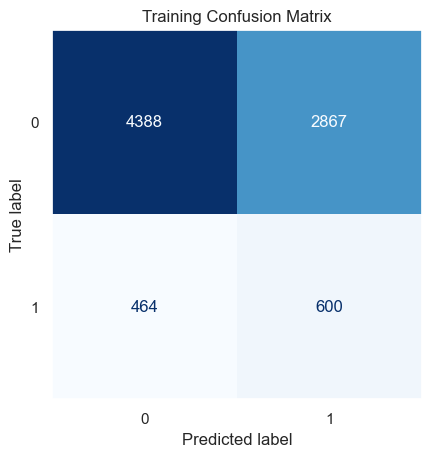

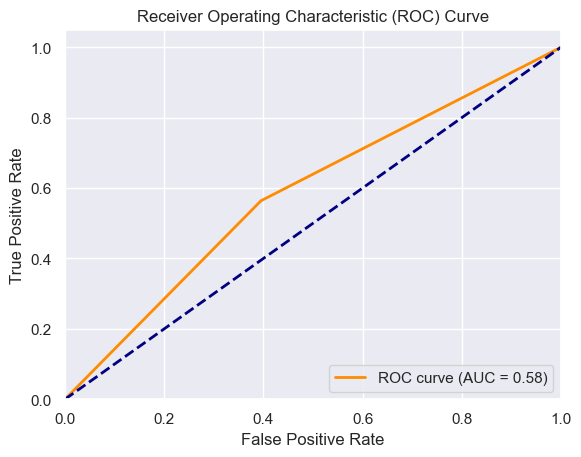

,Algorithm,Model,Description,DataType,BalancedAccuracy,RecallSensitivity,F1Score,AveragePrecision,Precision,Specificity,ROC_AUC_Score
0,RandomForestClassifier,rfc_one_fit,RandomForestClassifier - Grid Search - balanced_accuracy - F-Score >=10,Training,0.554291,0.462406,0.238661,0.143130,0.160837,0.646175,0.554291
1,RandomForestClassifier,rfc_one_fit,RandomForestClassifier - Grid Search - balanced_accuracy - F-Score >=10,Validation,0.548657,0.447368,0.233333,0.141279,0.157825,0.649945,0.548657
2,LogisticRegression,lrc_one_fit,LogisticRegression - Grid Search - balanced_accuracy - F-Score >=10,Training,0.584367,0.563910,0.264842,0.153366,0.173060,0.604824,0.584367


In [28]:
# display report - training
Specificity, RecallSensitivity, BalancedAccuracy, Precision, F1, AveragePrecision, AUC = classifier_metrics(model, X_train_scale_df[selectedFeatures], y_train, flag=False)

# initialize variable
Type = 'Training'

# add to DataFrame
df_metrics = metricsClassfication(Algorithm, Model, Desc, Type, Specificity, RecallSensitivity, BalancedAccuracy, Precision, F1, AveragePrecision, AUC)

# concat two dataframes
df_classfication = pd.concat([df_classfication, df_metrics], ignore_index=True)

# reset the index
df_classfication.reset_index(drop=True, inplace=True)

# dispaly
df_classfication

***** Classfication Metrics for Validation/Test:
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.61      0.72      1814
           1       0.16      0.50      0.24       266

    accuracy                           0.59      2080
   macro avg       0.52      0.55      0.48      2080
weighted avg       0.80      0.59      0.66      2080



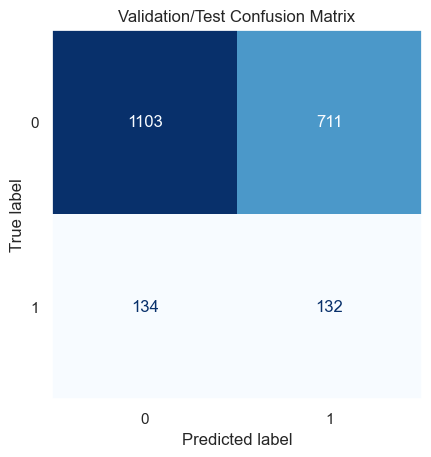

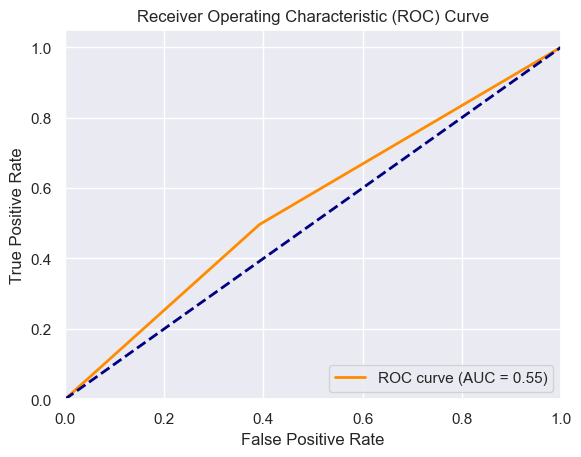

,Algorithm,Model,Description,DataType,BalancedAccuracy,RecallSensitivity,F1Score,AveragePrecision,Precision,Specificity,ROC_AUC_Score
0,RandomForestClassifier,rfc_one_fit,RandomForestClassifier - Grid Search - balanced_accuracy - F-Score >=10,Training,0.554291,0.462406,0.238661,0.143130,0.160837,0.646175,0.554291
1,RandomForestClassifier,rfc_one_fit,RandomForestClassifier - Grid Search - balanced_accuracy - F-Score >=10,Validation,0.548657,0.447368,0.233333,0.141279,0.157825,0.649945,0.548657
2,LogisticRegression,lrc_one_fit,LogisticRegression - Grid Search - balanced_accuracy - F-Score >=10,Training,0.584367,0.563910,0.264842,0.153366,0.173060,0.604824,0.584367
3,LogisticRegression,lrc_one_fit,LogisticRegression - Grid Search - balanced_accuracy - F-Score >=10,Validation,0.552145,0.496241,0.238052,0.142126,0.156584,0.608049,0.552145


In [29]:
# display report - validation
Specificity, RecallSensitivity, BalancedAccuracy, Precision, F1, AveragePrecision, AUC = classifier_metrics(model, X_val_scale_df[selectedFeatures], y_val, flag=True)

# initialize variable
Type = 'Validation'

# add to DataFrame
df_metrics = metricsClassfication(Algorithm, Model, Desc, Type, Specificity, RecallSensitivity, BalancedAccuracy, Precision, F1, AveragePrecision, AUC)

# concat two dataframes
df_classfication = pd.concat([df_classfication, df_metrics], ignore_index=True)

# reset the index
df_classfication.reset_index(drop=True, inplace=True)

# dispaly
df_classfication